# NICE-flow for optimum calibration for multiclass classification

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport calibrators
from utils.data import get_cifar10, get_cifar3, load_logits
from utils.ops import onehot_encode, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram
from utils.visualization import plot_cal_regions_ternary, ECE_plot_multi
from calibrators import PAVCalibrator, MLRCalibrator, NiceCalibrator, TempScalingCalibrator

In [4]:
%matplotlib inline
np.random.seed(1)

In [5]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

## Analysis on CIFAR3

Load dataset and logits:

In [6]:
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

Calibrate the model:

Temperature scaling fitted in 0.059s
MLR fitted in 0.020s
PAV fitted in 0.005s
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


NICE-flow fitted in 888.397s


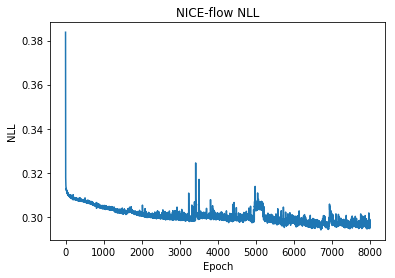

In [7]:
# Temp-scaling
t0 = time.time()
temp_cal = TempScalingCalibrator(logits, target)
print('Temperature scaling fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
mlr_cal = MLRCalibrator(logits, target)
print('MLR fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
pav_cal = PAVCalibrator(logits, target)
print('PAV fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
nice_cal = NiceCalibrator(logits, target, layers=4, hidden_size=[4, 4],
                          version=2, epochs=8000, batch_size=50)
print('NICE-flow fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

Compute calibration performance:

In [8]:
# Uncalibrated model
base_ece = expected_calibration_error(probs, target)
base_nll = neg_log_likelihood(probs, target)

# Temp-scaling
temp_probs = temp_cal.predict(logits)
temp_ece = expected_calibration_error(temp_probs, target)
temp_nll = neg_log_likelihood(temp_probs, target)

# MLR
mlr_probs = mlr_cal.predict(logits)
mlr_ece = expected_calibration_error(mlr_probs, target)
mlr_nll = neg_log_likelihood(mlr_probs, target)

# PAV
pav_probs = pav_cal.predict(logits)
pav_ece = expected_calibration_error(pav_probs, target)
pav_nll = neg_log_likelihood(pav_probs, target)

# NICE
nice_probs = nice_cal.predict(logits)
nice_ece = expected_calibration_error(nice_probs, target)
nice_nll = neg_log_likelihood(nice_probs, target)

Judge calibration:

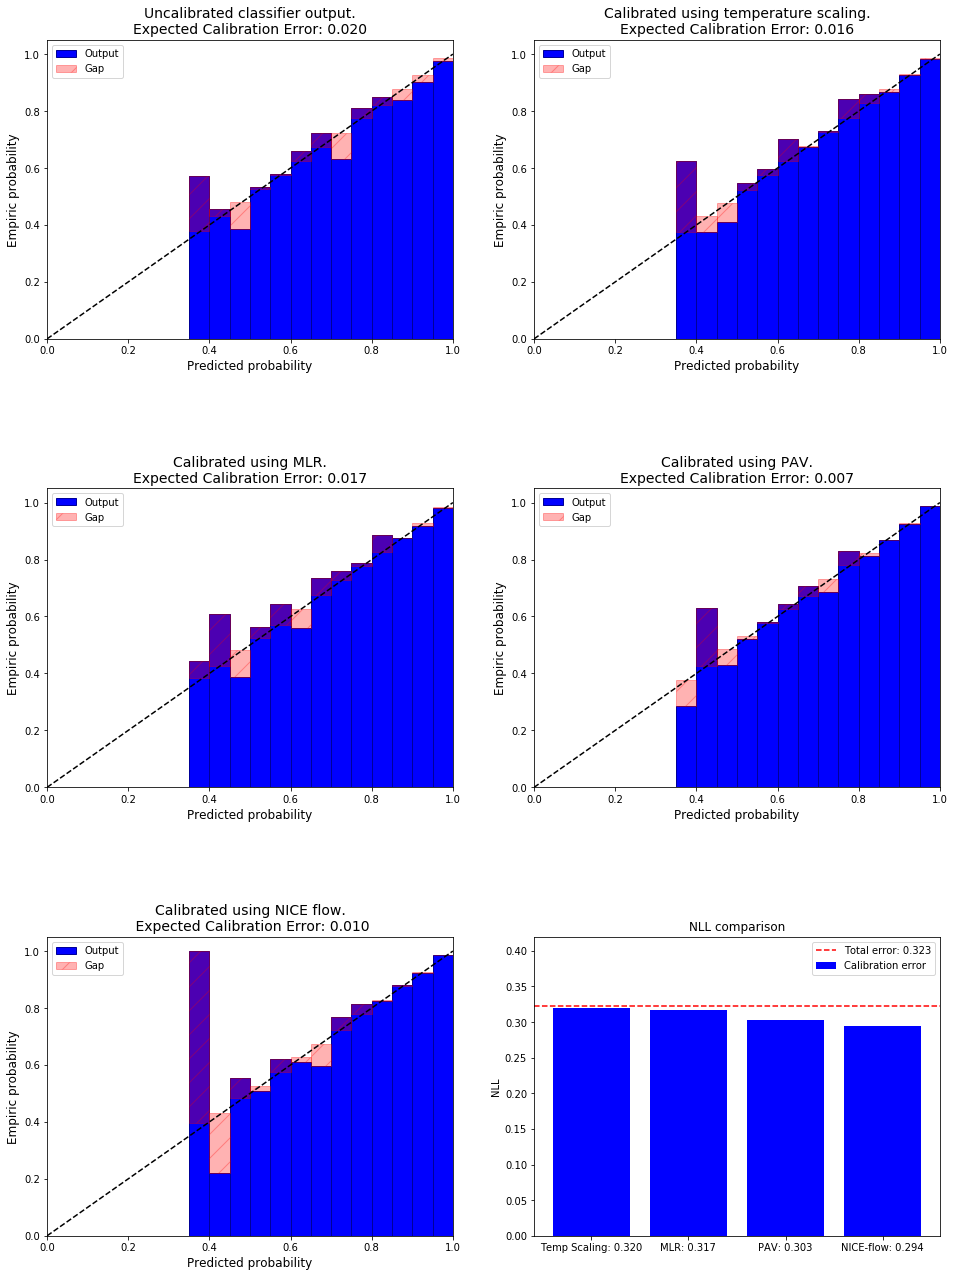

In [9]:
fig, ax_arr = plt.subplots(3, 2, figsize=(16, 22), gridspec_kw={'hspace': 0.5})
ax_arr[0, 0] = reliability_diagram(probs, target, ax=ax_arr[0, 0],
                             title='Uncalibrated classifier output.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(base_ece), fontsize=12);
ax_arr[0, 1] = reliability_diagram(temp_probs, target, ax=ax_arr[0, 1],
                             title='Calibrated using temperature scaling.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(temp_ece), fontsize=12);
ax_arr[1, 0] = reliability_diagram(mlr_probs, target, ax=ax_arr[1, 0],
                             title='Calibrated using MLR.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(mlr_ece), fontsize=12);
ax_arr[1, 1] = reliability_diagram(pav_probs, target, ax=ax_arr[1, 1],
                             title='Calibrated using PAV.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(pav_ece), fontsize=12);
ax_arr[2, 0] = reliability_diagram(nice_probs, target, ax=ax_arr[2, 0],
                             title='Calibrated using NICE flow.\n' +
                                   ' Expected Calibration Error: {:.3f}'.format(nice_ece), fontsize=12);
# NLL bar plot
nlls = np.array([temp_nll, mlr_nll, pav_nll, nice_nll])
ind = np.arange(4)
ticks = [
        'Temp Scaling: {:.3f}'.format(temp_nll),
        'MLR: {:.3f}'.format(mlr_nll),
        'PAV: {:.3f}'.format(pav_nll),
        'NICE-flow: {:.3f}'.format(nice_nll)
    ]

rects = ax_arr[2, 1].bar(ind, nlls, color='b', label='Calibration error')

ax_arr[2, 1].set_ylabel('NLL')
ax_arr[2, 1].set_title('NLL comparison')
ax_arr[2, 1].set_xticks(ind)
ax_arr[2, 1].set_xticklabels(ticks)
ax_arr[2, 1].set_ylim([0, max(nlls.max(), base_nll)*1.3])

ax_arr[2, 1].axhline(y=base_nll, color='r', ls='--', label='Total error: {:.3f}'.format(base_nll))
ax_arr[2, 1].legend()

plt.show()

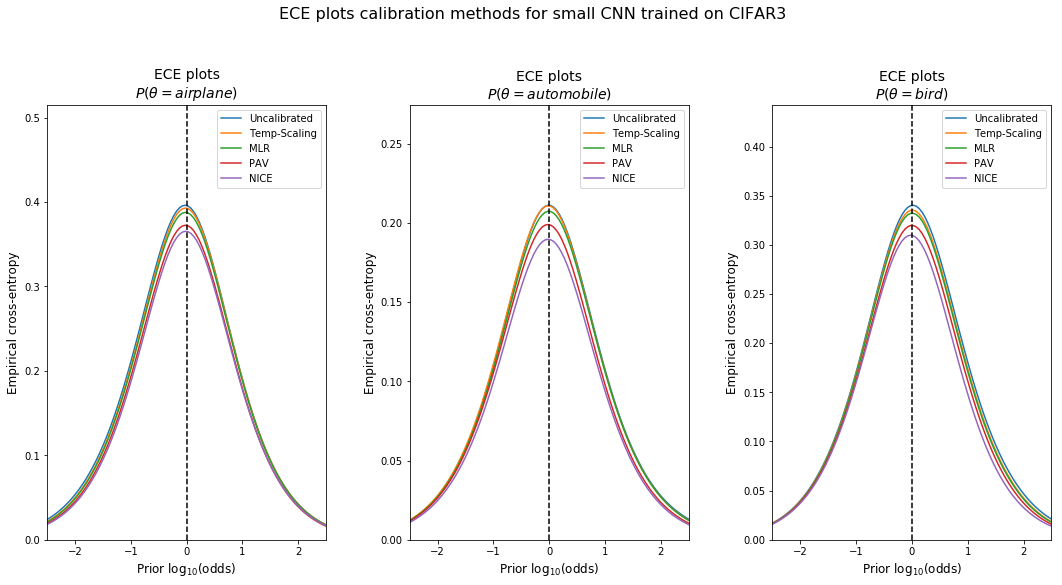

In [10]:
LRs_base = detection_log_likelihood_ratios(logits, np.zeros(3) + 1/3.)
LRs_temp = detection_log_likelihood_ratios(np.log(temp_probs + 1e-7), np.zeros(3) + 1/3.)
LRs_mlr = detection_log_likelihood_ratios(np.log(mlr_probs + 1e-7), np.zeros(3) + 1/3.)
LRs_pav = detection_log_likelihood_ratios(np.log(pav_probs + 1e-7), np.zeros(3) + 1/3.)
LRs_nice = detection_log_likelihood_ratios(np.log(nice_probs + 1e-7), np.zeros(3) + 1/3.)

LRs = [LRs_base, LRs_temp, LRs_mlr, LRs_pav, LRs_nice]

labels = ['Uncalibrated', 'Temp-Scaling', 'MLR', 'PAV', 'NICE']

fig, ax_arr = plt.subplots(1, 3, figsize=(18, 8), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})
fig.suptitle('ECE plots calibration methods for small CNN trained on CIFAR3',  y=1.05, fontsize=16)

ax_arr[0] = ECE_plot_multi([np.exp(LR[:, 0]) for LR in LRs], target[:, 0], ax=ax_arr[0], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[0]))
ax_arr[1] = ECE_plot_multi([np.exp(LR[:, 1]) for LR in LRs], target[:, 1], ax=ax_arr[1], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[1]))
ax_arr[2] = ECE_plot_multi([np.exp(LR[:, 2]) for LR in LRs], target[:, 2], ax=ax_arr[2], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[2]))
plt.show();

fig.savefig('../images/nice-calibration-optimum-cifar3.png', bbox_inches='tight', pad_inches=0.8)

## Analysis on CIFAR 10

In [12]:
model = 'resnet56_v2'

cifar10, ix2label = get_cifar10(cifar_dir, test=True)
target = onehot_encode(cifar10['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

Calibrate the model:

Temperature scaling fitted in 0.627s
MLR fitted in 1.326s
PAV fitted in 0.018s


C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


NICE-flow fitted in 414.611s


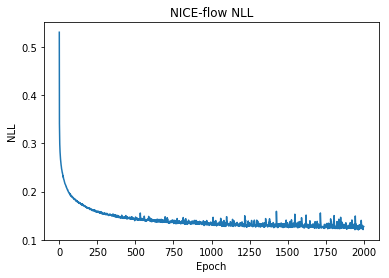

In [13]:
# Temp-scaling
t0 = time.time()
temp_cal = TempScalingCalibrator(logits, target)
print('Temperature scaling fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
mlr_cal = MLRCalibrator(logits, target)
print('MLR fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
pav_cal = PAVCalibrator(logits, target)
print('PAV fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
nice_cal = NiceCalibrator(logits, target, layers=4, hidden_size=[10, 10], epochs=2000)
print('NICE-flow fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

Compute calibration performance:

In [14]:
# Uncalibrated model
base_ece = expected_calibration_error(probs, target)
base_nll = neg_log_likelihood(probs, target)

# Temp-scaling
temp_probs = temp_cal.predict(logits)
temp_ece = expected_calibration_error(temp_probs, target)
temp_nll = neg_log_likelihood(temp_probs, target)

# MLR
mlr_probs = mlr_cal.predict(logits)
mlr_ece = expected_calibration_error(mlr_probs, target)
mlr_nll = neg_log_likelihood(mlr_probs, target)

# PAV
pav_probs = pav_cal.predict(logits)
pav_ece = expected_calibration_error(pav_probs, target)
pav_nll = neg_log_likelihood(pav_probs, target)

# NICE
nice_probs = nice_cal.predict(logits)
nice_ece = expected_calibration_error(nice_probs, target)
nice_nll = neg_log_likelihood(nice_probs, target)

Judge calibration:

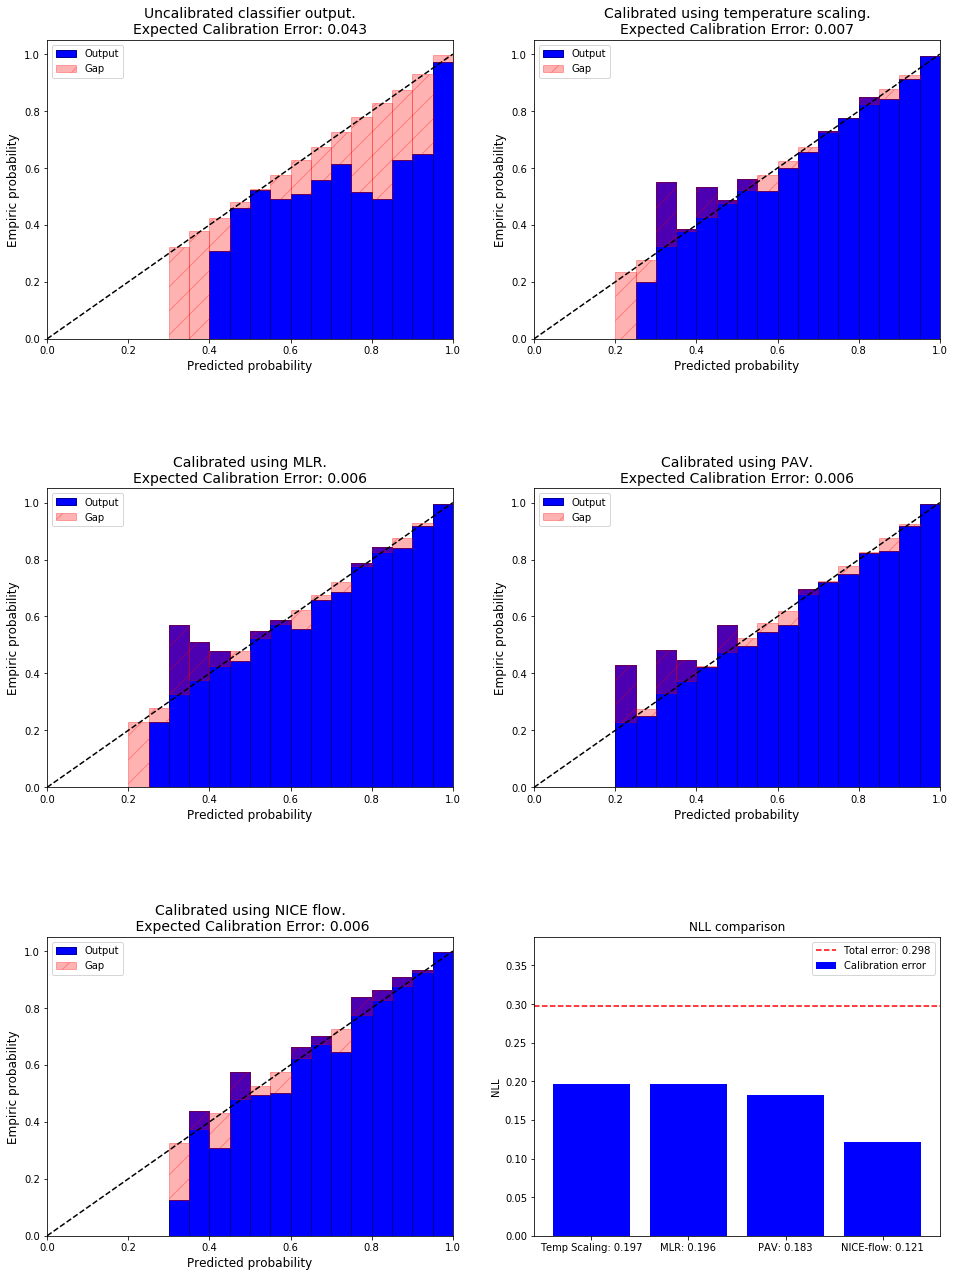

In [15]:
fig, ax_arr = plt.subplots(3, 2, figsize=(16, 22), gridspec_kw={'hspace': 0.5})
ax_arr[0, 0] = reliability_diagram(probs, target, ax=ax_arr[0, 0],
                             title='Uncalibrated classifier output.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(base_ece), fontsize=12);
ax_arr[0, 1] = reliability_diagram(temp_probs, target, ax=ax_arr[0, 1],
                             title='Calibrated using temperature scaling.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(temp_ece), fontsize=12);
ax_arr[1, 0] = reliability_diagram(mlr_probs, target, ax=ax_arr[1, 0],
                             title='Calibrated using MLR.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(mlr_ece), fontsize=12);
ax_arr[1, 1] = reliability_diagram(pav_probs, target, ax=ax_arr[1, 1],
                             title='Calibrated using PAV.\n' +
                                   'Expected Calibration Error: {:.3f}'.format(pav_ece), fontsize=12);
ax_arr[2, 0] = reliability_diagram(nice_probs, target, ax=ax_arr[2, 0],
                             title='Calibrated using NICE flow.\n' +
                                   ' Expected Calibration Error: {:.3f}'.format(nice_ece), fontsize=12);
# NLL bar plot
nlls = np.array([temp_nll, mlr_nll, pav_nll, nice_nll])
ind = np.arange(4)
ticks = [
        'Temp Scaling: {:.3f}'.format(temp_nll),
        'MLR: {:.3f}'.format(mlr_nll),
        'PAV: {:.3f}'.format(pav_nll),
        'NICE-flow: {:.3f}'.format(nice_nll)
    ]

rects = ax_arr[2, 1].bar(ind, nlls, color='b', label='Calibration error')

ax_arr[2, 1].set_ylabel('NLL')
ax_arr[2, 1].set_title('NLL comparison')
ax_arr[2, 1].set_xticks(ind)
ax_arr[2, 1].set_xticklabels(ticks)
ax_arr[2, 1].set_ylim([0, max(nlls.max(), base_nll)*1.3])

ax_arr[2, 1].axhline(y=base_nll, color='r', ls='--', label='Total error: {:.3f}'.format(base_nll))
ax_arr[2, 1].legend()

plt.show()

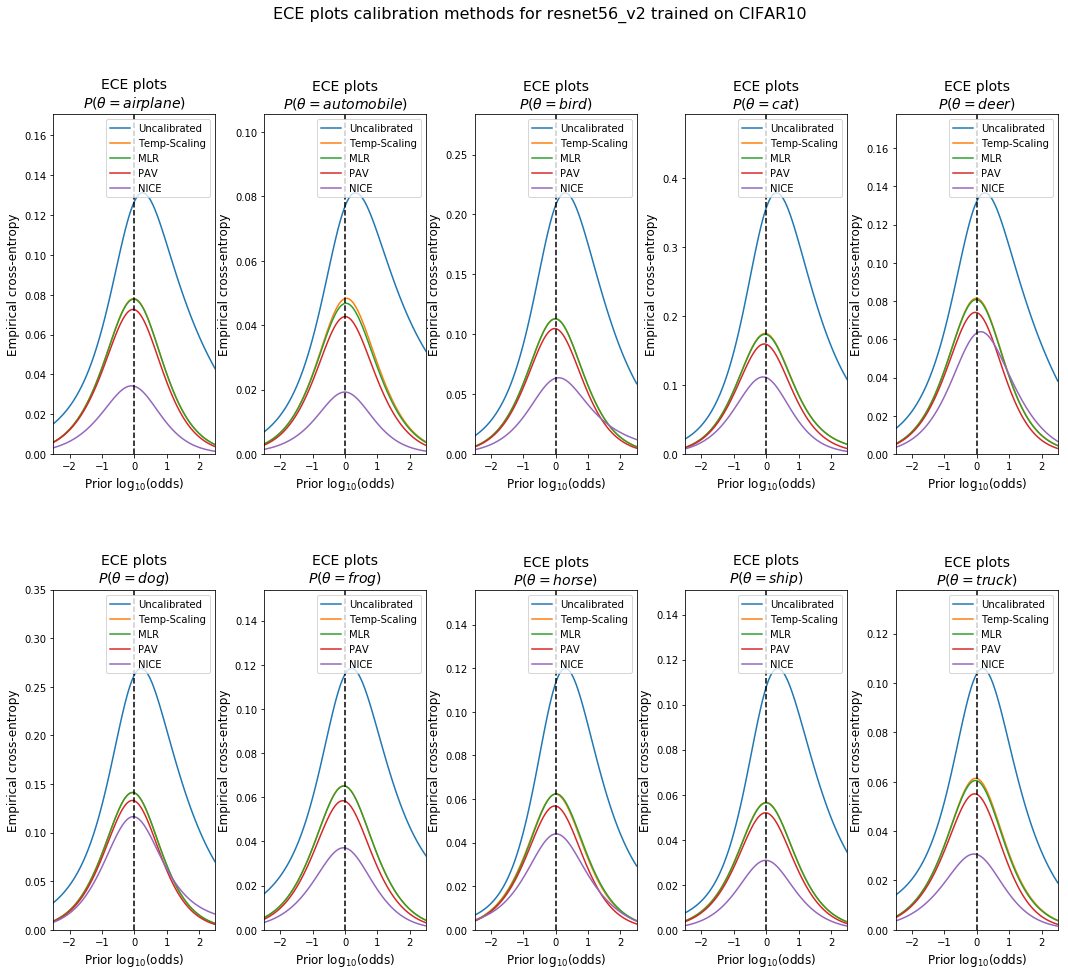

In [16]:
LRs_base = np.exp(detection_log_likelihood_ratios(logits, np.zeros(10) + 1/10.))
LRs_temp = np.exp(detection_log_likelihood_ratios(np.log(temp_probs + 1e-7), np.zeros(10) + 1/10.))
LRs_mlr = np.exp(detection_log_likelihood_ratios(np.log(mlr_probs + 1e-7), np.zeros(10) + 1/10.))
LRs_pav = np.exp(detection_log_likelihood_ratios(np.log(pav_probs + 1e-7), np.zeros(10) + 1/10.))
LRs_nice = np.exp(detection_log_likelihood_ratios(np.log(nice_probs + 1e-7), np.zeros(10) + 1/10.))

LRs = [LRs_base, LRs_temp, LRs_mlr, LRs_pav, LRs_nice]

labels = ['Uncalibrated', 'Temp-Scaling', 'MLR', 'PAV', 'NICE']

fig, ax_arr = plt.subplots(2, 5, figsize=(18, 15), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})
fig.suptitle('ECE plots calibration methods for resnet56_v2 trained on CIFAR10', fontsize=16)

ax_arr[0, 0] = ECE_plot_multi([LR[:, 0] for LR in LRs], target[:, 0], ax=ax_arr[0, 0], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[0]))
ax_arr[0, 1] = ECE_plot_multi([LR[:, 1] for LR in LRs], target[:, 1], ax=ax_arr[0, 1], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[1]))
ax_arr[0, 2] = ECE_plot_multi([LR[:, 2] for LR in LRs], target[:, 2], ax=ax_arr[0, 2], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[2]))
ax_arr[0, 3] = ECE_plot_multi([LR[:, 3] for LR in LRs], target[:, 3], ax=ax_arr[0, 3], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[3]))
ax_arr[0, 4] = ECE_plot_multi([LR[:, 4] for LR in LRs], target[:, 4], ax=ax_arr[0, 4], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[4]))

ax_arr[1, 0] = ECE_plot_multi([LR[:, 5] for LR in LRs], target[:, 5], ax=ax_arr[1, 0], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[5]))
ax_arr[1, 1] = ECE_plot_multi([LR[:, 6] for LR in LRs], target[:, 6], ax=ax_arr[1, 1], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[6]))
ax_arr[1, 2] = ECE_plot_multi([LR[:, 7] for LR in LRs], target[:, 7], ax=ax_arr[1, 2], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[7]))
ax_arr[1, 3] = ECE_plot_multi([LR[:, 8] for LR in LRs], target[:, 8], ax=ax_arr[1, 3], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[8]))
ax_arr[1, 4] = ECE_plot_multi([LR[:, 9] for LR in LRs], target[:, 9], ax=ax_arr[1, 4], ref=False,
                           labels=labels, title='ECE plots\n$P(\\theta={})$'.format(ix2label[9]))



plt.show();

fig.savefig('../images/nice-calibration-optimum-cifar10.png')